In [1]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

In [2]:
# import all from /raw_data/
all_acc_csvs = glob.glob(os.getcwd() + "/raw_data/accelerometer/*.csv")
all_gyro_csvs = glob.glob(os.getcwd() + "/raw_data/gyroscope/*.csv")

sensor_df = pd.DataFrame()
for acc_file, gyro_file in zip(all_acc_csvs, all_gyro_csvs):
    acc_df = pd.read_csv(acc_file).loc[:, ["Timestamp", "x", "y", "z", "payload"]] \
        .rename(columns={"x": "acc_x", "y": "acc_y", "z": "acc_z"})

    gyro_df = pd.read_csv(gyro_file).loc[:, ["Timestamp", "x", "y", "z", "payload"]] \
        .rename(columns={"x": "gyro_x", "y": "gyro_y", "z": "gyro_z"})

    combined_df = pd.merge_asof(acc_df.sort_values("Timestamp"), gyro_df.sort_values("Timestamp"), on="Timestamp", direction="nearest") \
        .loc[:, ["Timestamp", "acc_x", "acc_y", "acc_z", "gyro_x", "gyro_y", "gyro_z", "payload_x"]] \
            .rename(columns={"payload_x": "payload"})

    sensor_df = pd.concat([sensor_df, combined_df], axis=0)

print(sensor_df.head())

       Timestamp     acc_x     acc_y     acc_z    gyro_x    gyro_y    gyro_z  \
0  1636227071563  0.172474 -0.106599  9.778942  0.000666  0.002131  0.001731   
1  1636227071574  0.206610 -0.097017  9.807089  0.000666  0.002131  0.001731   
2  1636227071586  0.143729 -0.082644  9.754988  0.000666  0.002131  0.001731   
3  1636227071599  0.158102 -0.111390  9.825654  0.000666  0.002131  0.001731   
4  1636227071616  0.158102 -0.178463  9.759778  0.000666  0.002131  0.001731   

  payload  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN  


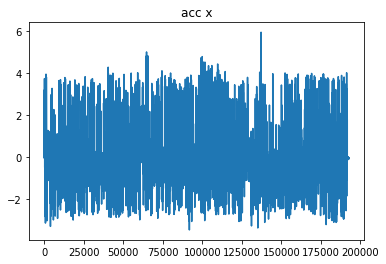

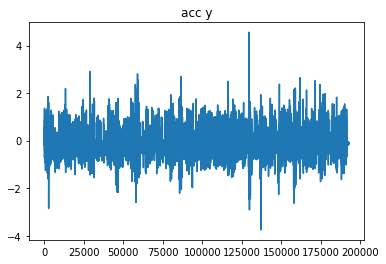

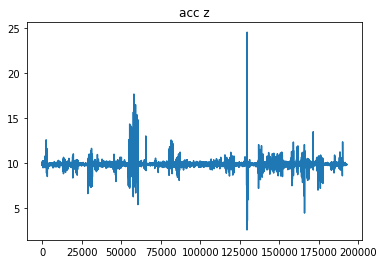

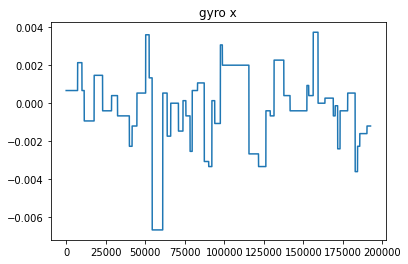

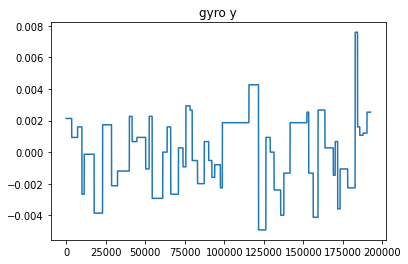

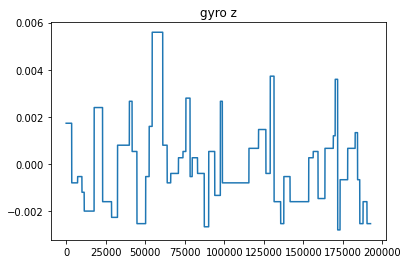

In [3]:
for sensor in ["acc", "gyro"]:
    plt.plot(range(len(sensor_df)), sensor_df[sensor + "_x"])
    plt.title(sensor + " x")
    plt.show()
    plt.plot(range(len(sensor_df)), sensor_df[sensor + "_y"])
    plt.title(sensor + " y")
    plt.show()
    plt.plot(range(len(sensor_df)), sensor_df[sensor + "_z"])
    plt.title(sensor + " z")
    plt.show()

In [4]:
current_payload = None
payload_change_indices = []
y_final_payload = []
df_size = len(sensor_df.values)
print("Payload: ")
for index, reading in enumerate(sensor_df.values):
    if str(reading[7]) != "nan" and reading[7] != current_payload:
        current_payload = reading[7]
        added_symbol = str(current_payload[-1])

        payload_change_indices.append(index)
        y_final_payload.append(added_symbol)
        print(added_symbol, end='')

#print("\n", "# of readings:", len(sensor_df.values))
print(" # of payload changes:", len(payload_change_indices))
#print(" Payload change indices:", payload_change_indices)

Payload: 
This is a test ofcf changes in data with no payload changesLllllllllllllkllllllllllllllollllllllllllllllllllllllllllAbcdefghijklmnopqrstuvwxyzHi there welcome to chilis sBbbnbbbbbbbbbbhbbbbbbbbnbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbPpppppppppppplppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppopppGgggggyggygggggggggghghgggggggggggggghggggygggggggggggggggggggggggggggggggggggggggggggggggggMmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmm.mmWwwwwwwwwwwwwwwwwwwwweewwwwwwwwwwwwwwwwwwwwwswwwwwwwweewwewwwewwwwwwwwwwwwwwwewwwwwwwwwwwwwwwwwwwwwwwwwwZxcvbnmlkjhgfdsaqwertyuiopzxcvfdtkslpzqmsSonic tilts his head sensuasly towards mario d do you really think im cute he asks,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,AbcdefgjhiklmnopqrstuvwxyzSsssssdssssssssssssssdsswsssssssQqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqaaqqqwwqqqqqqqqqqqqwqqqqqqqq

In [5]:
N_SURROUNDING = 10
X_sequences = [ range(index - N_SURROUNDING, index + N_SURROUNDING + 1) for index in payload_change_indices ]
important_indices = list(filter(lambda x: x >= 0 and x < df_size, set(np.concatenate(X_sequences))))

print("# of relevant readings:", len(important_indices))
#print(important_indices)

# of relevant readings: 70785


In [6]:
X = np.array([sensor_df.iloc[seq, 1:7].values for seq in X_sequences])
print("Sequence Rows:", X.shape)
y = np.array([char.lower() for char in y_final_payload]).reshape(-1,1)
print("Payload:", y)

Sequence Rows: (3470, 21, 6)
Payload: [['t']
 ['h']
 ['i']
 ...
 ['h']
 ['h']
 ['h']]


In [7]:
# transform the series data
scaler = StandardScaler()
for feature_idx in range(X.shape[1]):
    X[:, feature_idx] = scaler.fit_transform(X[:, feature_idx])

In [8]:
# plot the distribution of the data before oversampling
plt.hist(y, bins=100)
plt.title('Distribution of target character')
plt.xlabel('Target character')
plt.ylabel('Frequency')
plt.savefig(os.getcwd() + '/plots/target_distribution.png', facecolor='w', edgecolor='w',)
# plt.show()
plt.clf()

<Figure size 432x288 with 0 Axes>

In [9]:
# temporarily convert the data to 2d to oversample, then back to 3d
X_2d = X.reshape(-1, X.shape[1] * X.shape[2])
print("2d shape:", X_2d.shape)

X_over, y_over = SMOTE(random_state=42).fit_resample(X_2d, y)
print("Oversampled shape:", X_over.shape)

# reverse the reshape
X_over = X_over.reshape(-1, X.shape[1], X.shape[2])
print("3d shape:", X_over.shape)

2d shape: (3470, 126)
Oversampled shape: (7192, 126)
3d shape: (7192, 21, 6)


In [10]:
# plot the distribution of the target after oversampling
plt.hist(y_over, bins=100)
plt.title('Distribution of target character')
plt.xlabel('Target character')
plt.ylabel('Frequency')
plt.savefig(os.getcwd() + '/plots/target_distribution_oversampled.png', facecolor='w', edgecolor='w',)
# plt.show()
plt.clf()

<Figure size 432x288 with 0 Axes>

In [11]:
# plot the distribution of the oversampled data
titles = ["Distribution of " + sensor for sensor in ["acc_x", "acc_y", "acc_z", "gyro_x", "gyro_y", "gyro_z"]]
for feature_idx, title in zip(range(X_over.shape[2]), titles):
    plt.hist(X_over[:, feature_idx].reshape(-1,1), bins=100)
    plt.title(title)
    plt.xlabel('Sensor Value')
    plt.ylabel('Frequency')
    plt.savefig(os.getcwd() + '/plots/' + title + '.png', facecolor='w', edgecolor='w')
    # plt.show()
    plt.clf()

<Figure size 432x288 with 0 Axes>

In [12]:
# output to /processed_data/
np.save(os.getcwd() + "/processed_data/proc_X.npy", X_over)
np.save(os.getcwd() + "/processed_data/proc_y.npy", y_over)